# Notebook 4: Interpretación de Clusters y Conclusiones

## Contexto del proyecto

Este notebook es el **último paso** del Proyecto Final de Aprendizaje No Supervisado aplicado a una base histórica de créditos bancarios.

En los notebooks anteriores se realizó:

- **Notebook 1 – Exploración y Preprocesamiento**  
  Limpieza de datos, tratamiento de nulos y outliers, ingeniería de variables de riesgo (edad, antigüedad, ratios de mora, etc.) y generación del dataset estandarizado `data_processed.csv`.

- **Notebook 2 – Reducción de Dimensionalidad (PCA y UMAP)**  
  Obtención de componentes principales con PCA (≈83% de varianza explicada con 10 componentes) y de un embedding 2D con UMAP que reveló la estructura no lineal de la cartera.

- **Notebook 3 – Clustering (KMeans y DBSCAN)**  
  Aplicación de KMeans (varios k) y DBSCAN (distintos `eps` y `min_samples`), evaluación de métricas internas (Silhouette, Davies-Bouldin, Calinski-Harabasz) y selección de configuraciones finales de clusters. Se guardaron etiquetas de cluster y visualizaciones sobre UMAP 2D.

En este **Notebook 4** nos enfocamos exclusivamente en la **interpretación de resultados** y en traducirlos a **insights accionables para el negocio**.

---

## Objetivo del notebook

El objetivo principal es **analizar y explicar los clusters obtenidos**, respondiendo a preguntas como:

- ¿Qué caracteriza a cada grupo de clientes en términos de riesgo de crédito?
- ¿Qué diferencias existen entre los segmentos de bajo, medio y alto riesgo?
- ¿Qué recomendaciones operativas se pueden derivar (cobranza, límites, ofertas, etc.)?
- ¿Cómo se compara el comportamiento de KMeans y DBSCAN desde el punto de vista del negocio?

Este notebook sirve de puente entre la parte técnica (modelos) y la parte de **decisión gerencial**.

---

## Pasos que se realizan en este notebook

1. **Carga del dataset con clusters**
   - Lectura del dataset final que incluye:
     - Variables de riesgo (mora, saldos, límites, ratios, calificación).
     - Etiquetas de cluster de KMeans (k=2 y k=5).
     - Etiquetas de cluster de DBSCAN (incluyendo ruido).
   - Verificación de dimensiones y estructura.

2. **Resumen de tamaños de clusters**
   - Conteo de observaciones por cluster:
     - KMeans (k=5) – segmentación principal.
     - KMeans (k=2) – visión agregada “cartera sana vs. cartera riesgosa”.
     - DBSCAN – clusters densos y puntos de ruido.

3. **Perfilamiento cuantitativo de clusters**
   - Cálculo de medias por cluster para variables clave:
     - Días de mora, valor de mora, ratio de mora, mora ≥30 días.
     - Límites y saldos.
     - Antigüedad y meses a vencimiento.
     - Distribución de calificaciones (A2, B, C, D, E).
   - Construcción de **tablas resumen** y **heatmaps de z-scores** que muestran qué variables están por encima o por debajo de la media en cada cluster.

4. **Interpretación de clusters**
   - Definición de perfiles tipo:
     - Clusters de **clientes sanos sin mora**.
     - Clientes con **buen rating pero mora reciente**.
     - Segmentos de **alto riesgo** con fuerte concentración en calificaciones D/E.
   - Comparación entre la segmentación de KMeans y la de DBSCAN:
     - Qué tan consistentes son los grupos.
     - Cómo trata cada algoritmo los outliers / ruido.

5. **Insights de negocio y recomendaciones**
   - Propuestas de uso de los clusters para:
     - Estrategias de cobranza (temprana vs. intensiva).
     - Políticas de crédito (límites, precios, renovaciones).
     - Priorización de esfuerzos sobre segmentos críticos.

6. **Limitaciones y trabajo futuro**
   - Comentarios sobre las limitaciones del análisis (variables disponibles, supuestos de preprocesamiento, elección de hiperparámetros, ausencia de verdad-terreno).
   - Ideas para extender el trabajo (nuevas variables, otros algoritmos, validación con comportamiento futuro).

---

## Resultado esperado

Al finalizar este notebook se obtiene:

- Una **caracterización clara de cada cluster**, tanto con KMeans como con DBSCAN.
- **Visualizaciones** que muestran cómo se agrupan los clientes en el espacio UMAP y qué variables distinguen a cada grupo.
- Un conjunto de **insights accionables** para la gestión de la cartera de crédito.
- Un resumen ordenado que se puede reutilizar directamente en el **informe técnico (PDF)** y en la **presentación ejecutiva** del proyecto.


In [1]:
# 1. Carga de datos con clusters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams["figure.figsize"] = (8, 6)

# Cargar el dataset con clusters generado en el Notebook 3
df = pd.read_csv("data_with_clusters.csv")

print("Shape del dataset con clusters:", df.shape)
print("\nColumnas principales:")
print(df.columns.tolist())


Shape del dataset con clusters: (26559, 42)

Columnas principales:
['Numero Dias Mora', 'Valor Limite', 'Valor Saldo Total', 'Valor Mora Total', 'Valor Cuota', 'edad', 'antiguedad_meses', 'meses_a_vencimiento', 'sin_vencimiento', 'ratio_mora', 'ratio_saldo_limite', 'mora_30', 'Tipo de Sujeto_J', 'Sexo_M', 'Tipo de obligación_CON', 'Tipo de obligación_MIC', 'Tipo de obligación_TDC', 'Tipo de obligación_TIC', 'Periodo de Pago_OTR', 'Periodo de Pago_QIN', 'Periodo de Pago_VEN', 'Estado_VIG', 'Sub-estado_CJU', 'Sub-estado_MOR', 'Sub-estado_VEN', 'Sub-estado_VIG', 'Sub-estado_VOL', 'Tipo de Garantia_FID', 'Tipo de Garantia_HIP', 'Tipo de Garantia_SGR', 'Calificacion_A2', 'Calificacion_B', 'Calificacion_C1', 'Calificacion_C2', 'Calificacion_D1', 'Calificacion_D2', 'Calificacion_E', 'cluster_k2', 'cluster_k8', 'cluster_dbscan', 'is_noise_dbscan', 'cluster_k5']


=== RESUMEN DE CLUSTERS ===

Tamaño de clusters KMeans (k=5):
cluster_k5
0    3658
1    4150
2    7132
3    5009
4    6610
Name: count, dtype: int64

Tamaño de clusters KMeans (k=2):
cluster_k2
0    11859
1    14700
Name: count, dtype: int64

Tamaño de clusters DBSCAN (incluye -1 como ruido):
cluster_dbscan
-1     279
 0    3818
 1    5040
 2    7312
 3    1700
 4    8410
Name: count, dtype: int64


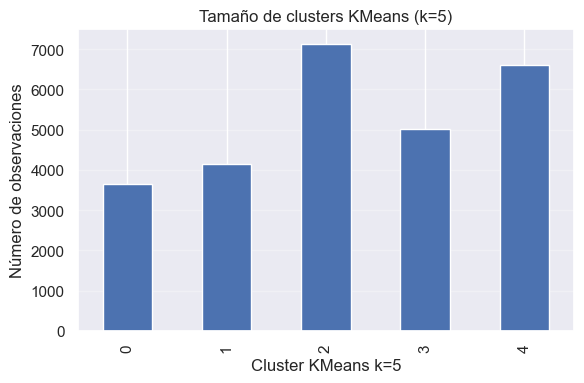

In [2]:
# 2. Resumen de soluciones de clustering

print("=== RESUMEN DE CLUSTERS ===")

# KMeans k=5
print("\nTamaño de clusters KMeans (k=5):")
counts_k5 = df["cluster_k5"].value_counts().sort_index()
print(counts_k5)

# KMeans k=2 (por si lo mencionas en el informe)
print("\nTamaño de clusters KMeans (k=2):")
counts_k2 = df["cluster_k2"].value_counts().sort_index()
print(counts_k2)

# DBSCAN (incluye ruido -1)
print("\nTamaño de clusters DBSCAN (incluye -1 como ruido):")
counts_db = df["cluster_dbscan"].value_counts().sort_index()
print(counts_db)

# Gráfico rápido de tamaños KMeans k=5
plt.figure(figsize=(6,4))
counts_k5.plot(kind="bar")
plt.xlabel("Cluster KMeans k=5")
plt.ylabel("Número de observaciones")
plt.title("Tamaño de clusters KMeans (k=5)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
# 3. Perfilamiento de clusters KMeans (k=5)

print("=== PERFILES DE CLUSTERS KMEANS (k=5) ===")

features_clave = [
    "Numero Dias Mora",
    "Valor Limite",
    "Valor Saldo Total",
    "Valor Mora Total",
    "Valor Cuota",
    "edad",
    "antiguedad_meses",
    "meses_a_vencimiento",
    "ratio_mora",
    "ratio_saldo_limite",
    "mora_30",
    "Calificacion_A2",
    "Calificacion_B",
    "Calificacion_C1",
    "Calificacion_C2",
    "Calificacion_D1",
    "Calificacion_D2",
    "Calificacion_E",
]

# Nos quedamos solo con las columnas que existen
features_clave = [c for c in features_clave if c in df.columns]

print("Variables usadas para el perfilado:")
print(features_clave)

# Tamaño de cada cluster
print("\nTamaño de cada cluster KMeans (k=5):")
print(df["cluster_k5"].value_counts().sort_index())

# Perfiles promedio (recuerda: variables estandarizadas)
profiles_k5 = df.groupby("cluster_k5")[features_clave].mean()
profiles_k5


=== PERFILES DE CLUSTERS KMEANS (k=5) ===
Variables usadas para el perfilado:
['Numero Dias Mora', 'Valor Limite', 'Valor Saldo Total', 'Valor Mora Total', 'Valor Cuota', 'edad', 'antiguedad_meses', 'meses_a_vencimiento', 'ratio_mora', 'ratio_saldo_limite', 'mora_30', 'Calificacion_A2', 'Calificacion_B', 'Calificacion_C1', 'Calificacion_C2', 'Calificacion_D1', 'Calificacion_D2', 'Calificacion_E']

Tamaño de cada cluster KMeans (k=5):
cluster_k5
0    3658
1    4150
2    7132
3    5009
4    6610
Name: count, dtype: int64


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
cluster_k5,,,,,,,,,,,,,,,,,,
0,-0.145503,0.757070,1.158083,1.981645,0.004995,0.033641,-0.239783,0.123033,0.695149,0.709616,0.224829,0.000000,0.341443,0.133953,0.076818,0.414981,0.012302,0.020503
1,-0.926575,0.447642,1.314577,-0.800538,0.024698,0.022792,-0.751606,0.233259,-1.412930,1.224389,-1.098050,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.858006,-0.195940,-0.502883,0.010744,0.043793,0.039480,0.594434,-0.251992,0.710470,-0.468367,0.905072,0.000280,0.001683,0.058188,0.057487,0.524958,0.093102,0.264162
3,0.819281,-0.151836,-0.475097,0.044332,-0.068872,-0.009140,0.490059,-0.015963,0.710470,-0.454924,0.904289,0.000200,0.002396,0.066480,0.063486,0.521461,0.089639,0.256339
4,-0.884348,-0.373538,-0.563606,-0.639230,-0.013332,-0.068599,-0.408157,0.069453,-0.802573,-0.311328,-1.096834,0.021785,0.224357,0.000605,0.000000,0.000000,0.000000,0.031467


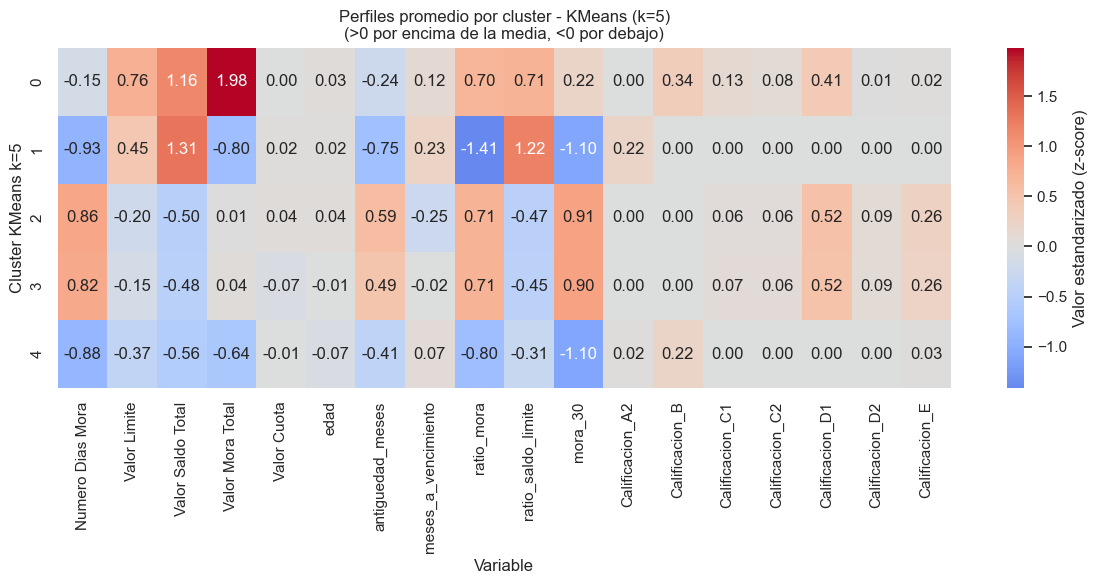

In [4]:
# 3.2 - Heatmap de perfiles KMeans (k=5)

plt.figure(figsize=(12, 6))

sns.heatmap(
    profiles_k5,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Valor estandarizado (z-score)"}
)

plt.title("Perfiles promedio por cluster - KMeans (k=5)\n(>0 por encima de la media, <0 por debajo)")
plt.ylabel("Cluster KMeans k=5")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()


In [5]:
# 4. Perfilamiento de clusters DBSCAN

print("=== PERFILES DE CLUSTERS DBSCAN (sin incluir ruido -1) ===")

features_clave = [
    "Numero Dias Mora",
    "Valor Limite",
    "Valor Saldo Total",
    "Valor Mora Total",
    "Valor Cuota",
    "edad",
    "antiguedad_meses",
    "meses_a_vencimiento",
    "ratio_mora",
    "ratio_saldo_limite",
    "mora_30",
    "Calificacion_A2",
    "Calificacion_B",
    "Calificacion_C1",
    "Calificacion_C2",
    "Calificacion_D1",
    "Calificacion_D2",
    "Calificacion_E",
]

features_clave = [c for c in features_clave if c in df.columns]

print("Variables usadas para el perfilado:")
print(features_clave)

print("\nTamaño de clusters DBSCAN (incluye -1 como ruido):")
print(df["cluster_dbscan"].value_counts().sort_index())

# Solo clusters reales (excluimos ruido -1)
mask_real = df["cluster_dbscan"] != -1
profiles_db = df[mask_real].groupby("cluster_dbscan")[features_clave].mean()
profiles_db


=== PERFILES DE CLUSTERS DBSCAN (sin incluir ruido -1) ===
Variables usadas para el perfilado:
['Numero Dias Mora', 'Valor Limite', 'Valor Saldo Total', 'Valor Mora Total', 'Valor Cuota', 'edad', 'antiguedad_meses', 'meses_a_vencimiento', 'ratio_mora', 'ratio_saldo_limite', 'mora_30', 'Calificacion_A2', 'Calificacion_B', 'Calificacion_C1', 'Calificacion_C2', 'Calificacion_D1', 'Calificacion_D2', 'Calificacion_E']

Tamaño de clusters DBSCAN (incluye -1 como ruido):
cluster_dbscan
-1     279
 0    3818
 1    5040
 2    7312
 3    1700
 4    8410
Name: count, dtype: int64


,Numero Dias Mora,Valor Limite,Valor Saldo Total,Valor Mora Total,Valor Cuota,edad,antiguedad_meses,meses_a_vencimiento,ratio_mora,ratio_saldo_limite,mora_30,Calificacion_A2,Calificacion_B,Calificacion_C1,Calificacion_C2,Calificacion_D1,Calificacion_D2,Calificacion_E
cluster_dbscan,,,,,,,,,,,,,,,,,,
0,-0.926575,0.009282,0.357155,-0.800538,-0.087145,-0.063722,-0.592998,-0.015963,-1.412930,0.467049,-1.098050,0.108172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.926575,0.020498,0.339445,-0.800538,0.052033,-0.010863,-0.563163,0.258624,-1.412930,0.433739,-1.098050,0.106944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.440695,0.014179,-0.153180,0.425439,-0.051273,0.004615,0.242492,-0.015963,0.707153,-0.213106,0.537086,0.005607,0.160558,0.071663,0.057303,0.442560,0.063457,0.192560
3,-0.759054,-0.040146,-0.038524,0.555967,0.060108,-0.001402,-0.418090,0.202566,0.703714,-0.006955,-1.098050,0.033529,0.874118,0.000000,0.000000,0.000000,0.000000,0.061765
4,0.754994,-0.040472,-0.262435,0.299976,0.036709,0.029818,0.476520,-0.172510,0.709861,-0.309845,0.910705,0.000000,0.000000,0.078002,0.067063,0.545541,0.081688,0.227705


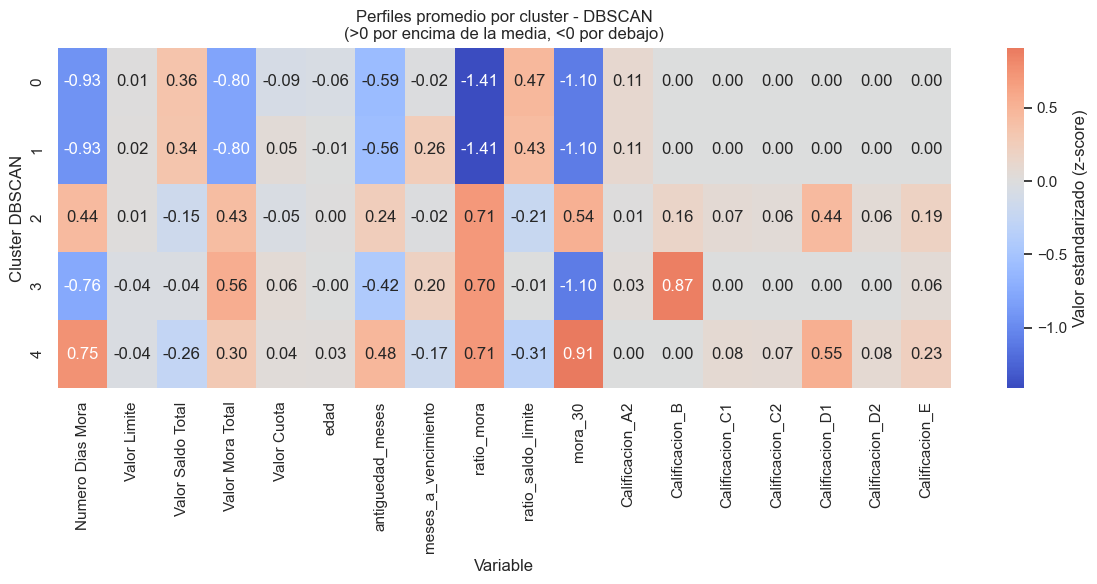

In [6]:
# 4.2 - Heatmap de perfiles DBSCAN

plt.figure(figsize=(12, 6))

sns.heatmap(
    profiles_db,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "Valor estandarizado (z-score)"}
)

plt.title("Perfiles promedio por cluster - DBSCAN\n(>0 por encima de la media, <0 por debajo)")
plt.ylabel("Cluster DBSCAN")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()


## Resultados de clustering

### KMeans (k = 5)

El modelo KMeans con k=5 genera cinco segmentos bien diferenciados:

- **Cluster 1 (k=5=1) – Clientes sanos, alto límite, sin mora**  
  - Días de mora y ratio de mora claramente por debajo de la media.  
  - Límites y saldos por encima de la media.  
  - Alta proporción de calificación A2.  

- **Cluster 2 (k=5=4) – Clientes sanos de bajo monto**  
  - Sin mora relevante, pero con límites y saldos por debajo de la media.  
  - Mezcla de calificaciones A2 y B; cartera de bajo riesgo pero ticket pequeño.  

- **Cluster 3 (k=5=0) – Clientes de límite alto con mora significativa**  
  - Límites y saldos claramente superiores a la media.  
  - Ratio de mora y mora monetaria elevados, con presencia importante de calificaciones D1–E.  

- **Clusters 4 y 5 (k=5=2 y 3) – Cartera de alto riesgo**  
  - Días de mora, ratio de mora y mora ≥30 días muy por encima de la media.  
  - Obligaciones más antiguas.  
  - Fuerte concentración en calificaciones D y E.  

En conjunto, KMeans permite distinguir entre clientes sanos de bajo y alto monto, un grupo intermedio con alto límite y mora relevante, y dos segmentos de alto riesgo.

### DBSCAN (eps = 1.5, min_samples = 10)

DBSCAN detecta automáticamente 5 clusters “densos” y un conjunto de observaciones consideradas ruido (-1). En el embedding UMAP 2D, estos clusters se alinean muy bien con las nubes de puntos:

- **Clusters 0 y 1 – Clientes sin mora**  
  - Ratio de mora y mora ≥30 días muy por debajo de la media.  
  - Límites y saldos cercanos o ligeramente superiores a la media.  
  - Predomina la calificación A2.  

- **Cluster 3 – Clientes con buena calificación pero mora reciente**  
  - Calificación principalmente B, con algo de A2 y E.  
  - Ratio de mora elevado, pero poca mora ≥30 días, sugiriendo atrasos recientes.  

- **Cluster 2 y 4 – Clientes de mayor riesgo**  
  - Días de mora y ratio de mora muy superiores a la media, con alta proporción de mora ≥30 días.  
  - Obligaciones más antiguas.  
  - Fuerte concentración en calificaciones D y E, especialmente en el cluster 4.  

- **Ruido (-1)**  
  - Conjunto pequeño de observaciones (≈1 %) que no pertenecen claramente a ningún grupo y representan comportamientos atípicos.

### Comparación entre algoritmos

- **KMeans k=5** ofrece una segmentación más “equilibrada” y fácilmente interpretable para negocio (clusters de tamaño similar y fronteras suaves).  
- **DBSCAN** respeta mejor la estructura no lineal observada en UMAP y permite identificar ruido y clusters de densidad, diferenciando de forma más clara los grupos sanos y de alto riesgo.  

En la práctica, los resultados de ambos métodos son consistentes: identifican dos grandes segmentos de clientes sanos sin mora, un grupo intermedio con buen rating pero mora reciente, y uno o dos grupos de alto riesgo con fuerte deterioro de cartera.


## Insights de negocio

A partir de los clusters obtenidos (principalmente con DBSCAN, que respeta mejor la estructura no lineal de los datos), se destacan los siguientes hallazgos:

1. **Dos segmentos grandes de clientes sanos sin mora (clusters 0 y 1)**  
   - Días de mora, ratio de mora y mora ≥30 días muy por debajo de la media.  
   - Niveles de saldo y límite cercanos o ligeramente superiores al promedio.  
   - Predominan calificaciones A2, con muy baja presencia de D/E.  
   → Este grupo representa la **base saludable del portafolio**; son candidatos para cross-sell, aumento de límite y ofertas de productos adicionales.

2. **Segmento de clientes con buena calificación pero mora reciente (cluster 3)**  
   - Calificación mayoritariamente B.  
   - Ratio de mora elevado, pero casi sin mora ≥30 días.  
   → Corresponde a **clientes en atraso temprano**. Son buenos candidatos para estrategias de recordatorio y regularización temprana (campañas de cobranza preventiva, refinanciamientos simples).

3. **Dos clusters de alto riesgo con fuerte deterioro (clusters 2 y 4)**  
   - Días de mora, ratio de mora y mora ≥30 días muy por encima de la media.  
   - Mayor antigüedad de la obligación.  
   - Altísima proporción de calificaciones D1, D2 y E.  
   → Constituyen la **cartera crítica**: aquí deberían enfocarse las acciones intensivas de cobranza, renegociación estructural o castigo, según las políticas del banco.

4. **Ruido (observaciones atípicas)**  
   - Un pequeño porcentaje de operaciones es clasificado como ruido por DBSCAN.  
   → Estas observaciones pueden corresponder a casos muy particulares (montos extremos, comportamientos poco frecuentes) y conviene revisarlas de forma individual.


## Conclusiones

- Las técnicas de **reducción de dimensionalidad** (PCA y UMAP) permitieron representar un portafolio de ~26 mil créditos en pocas dimensiones de forma interpretable. PCA explicó ~83% de la varianza con 10 componentes, mientras que UMAP reveló estructuras no lineales claras en el espacio 2D.

- Los algoritmos de **clustering** (KMeans y DBSCAN) identificaron de forma consistente:
  - Dos grandes grupos de clientes **sanos y sin mora**,  
  - Un grupo intermedio con **buen rating pero mora reciente**,  
  - Y uno/dos grupos de **alto riesgo**, con elevada mora monetaria y fuerte concentración en calificaciones D/E.

- DBSCAN, apoyado en el embedding de UMAP, separó de forma más natural las nubes de datos y permitió identificar un pequeño conjunto de observaciones atípicas (ruido), aportando una visión complementaria a la segmentación de KMeans.

- Desde el punto de vista de negocio, los clusters obtenidos pueden utilizarse para **diseñar estrategias diferenciadas de gestión de cartera**, priorizando la contención de la mora severa y el mantenimiento de la base de clientes sanos.

En conjunto, el análisis demuestra que el **aprendizaje no supervisado** es una herramienta útil para entender la estructura de riesgo de un portafolio de crédito y para apoyar la toma de decisiones estratégicas en gestión de cartera.
